In [1]:
file_path = '/content/drive/MyDrive/Project/1st/world_100bin_mod.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv(file_path)

In [4]:
# === 2. Preprocessing ===
df = df[df['reporting_level'] == 'national'].copy()
required_cols = ['country_code', 'year', 'percentile', 'pop_share', 'welfare_share', 'avg_welfare', 'quantile', 'pop']
assert all(col in df.columns for col in required_cols), "Missing required columns"
df.dropna(subset=required_cols, inplace=True)
df = df[df['pop_share'] > 0]

In [5]:
# === 3. Gini Function ===
def calculate_gini(group):
    group = group.sort_values(by='percentile')
    group['cum_pop'] = group['pop_share'].cumsum()
    group['cum_welfare'] = group['welfare_share'].cumsum()

    x = group['cum_pop'].values
    y = group['cum_welfare'].values

    x = np.insert(x, 0, 0)
    y = np.insert(y, 0, 0)

    gini = 1 - np.sum((y[1:] + y[:-1]) * (x[1:] - x[:-1]))
    return gini

In [6]:
# === 4. Lorenz Curve Plot ===
def plot_lorenz_curve(group, country_code, year):
    group = group.sort_values(by='percentile')
    group['cum_pop'] = group['pop_share'].cumsum()
    group['cum_welfare'] = group['welfare_share'].cumsum()

    plt.figure(figsize=(6, 6))
    plt.plot(group['cum_pop'], group['cum_welfare'], label='Lorenz Curve')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Line of Equality')
    plt.title(f'Lorenz Curve - {country_code} ({year})')
    plt.xlabel('Cumulative Population Share')
    plt.ylabel('Cumulative Income Share')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
# === 5. Calculate Gini Across Dataset ===
gini_records = []
for (country, year), group in df.groupby(['country_code', 'year']):
    try:
        gini = calculate_gini(group)
        gini_records.append({
            'country_code': country,
            'year': year,
            'gini': gini
        })
    except Exception as e:
        print(f"Skipped {country}-{year}: {e}")

gini_df = pd.DataFrame(gini_records)

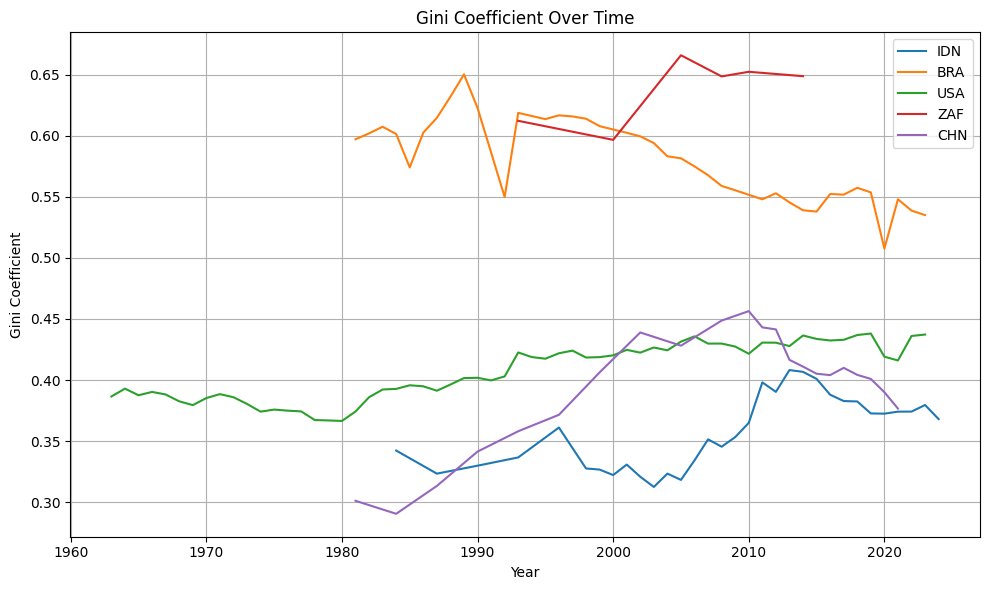

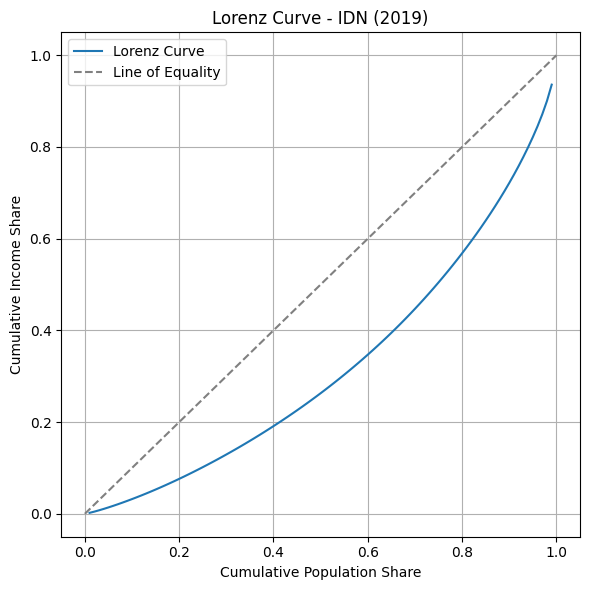

In [8]:
# === 6. Visualizations ===
selected_countries = ['IDN', 'BRA', 'USA', 'ZAF', 'CHN']
plt.figure(figsize=(10,6))
for code in selected_countries:
    subset = gini_df[gini_df['country_code'] == code]
    plt.plot(subset['year'], subset['gini'], label=code)
plt.title('Gini Coefficient Over Time')
plt.xlabel('Year')
plt.ylabel('Gini Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

latest_year = gini_df.groupby('country_code')['year'].max().reset_index()
gini_latest = pd.merge(gini_df, latest_year, on=['country_code', 'year'])
fig = px.choropleth(
    gini_latest,
    locations="country_code",
    color="gini",
    hover_name="country_code",
    color_continuous_scale="Reds",
    title="Global Gini Coefficient (Most Recent Year Available)"
)
fig.show()

example_group = df[(df['country_code'] == 'IDN') & (df['year'] == 2019)]
plot_lorenz_curve(example_group, 'IDN', 2019)

In [9]:
# === 7. Income Redistribution Simulation ===
def simulate_redistribution(group, increment=0.5, top_cutoff=50):
    group = group.copy()
    group['sim_avg_welfare'] = group['avg_welfare']
    group.loc[group['percentile'] <= top_cutoff, 'sim_avg_welfare'] += increment

    group['sim_total'] = group['sim_avg_welfare'] * group['pop']
    total_sim = group['sim_total'].sum()
    group['sim_welfare_share'] = group['sim_total'] / total_sim

    # Ensure that sum welfare_share = 1
    group['sim_welfare_share'] = group['sim_welfare_share'] / group['sim_welfare_share'].sum()

    sim_df = group[['percentile', 'pop_share', 'sim_welfare_share']].rename(columns={'sim_welfare_share': 'welfare_share'})
    return calculate_gini(sim_df), sim_df

sim_gini, sim_group = simulate_redistribution(example_group)
original_gini = calculate_gini(example_group)
print(f"Gini Before: {original_gini:.4f}, After Redistribution: {sim_gini:.4f}")

Gini Before: 0.3728, After Redistribution: 0.3020


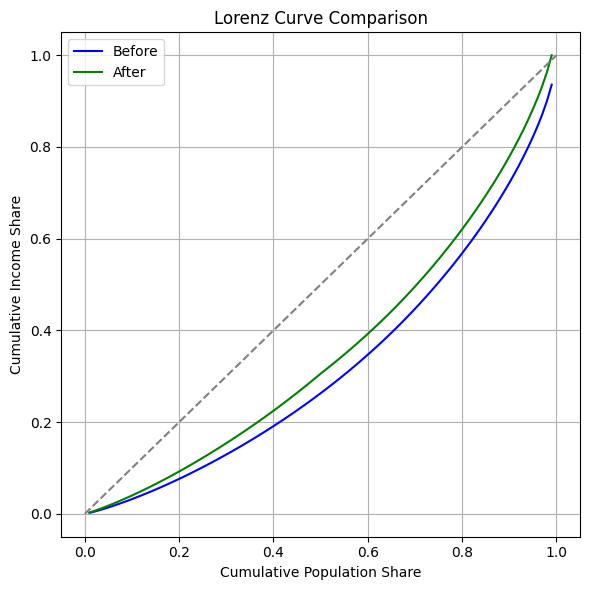

In [10]:
# === 8. Visualisasi Before vs After Redistribusi ===
def preprocess_for_lorenz(group):
    group = group.sort_values(by='percentile')
    group['cum_pop'] = group['pop_share'].cumsum()
    group['cum_welfare'] = group['welfare_share'].cumsum()
    return group

def plot_lorenz_comparison(before_group, after_group, title='Lorenz Curve Comparison'):
    plt.figure(figsize=(6, 6))
    plt.plot(before_group['cum_pop'], before_group['cum_welfare'], label='Before', color='blue')
    plt.plot(after_group['cum_pop'], after_group['cum_welfare'], label='After', color='green')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('Cumulative Population Share')
    plt.ylabel('Cumulative Income Share')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

before = preprocess_for_lorenz(example_group)
after = preprocess_for_lorenz(sim_group)
plot_lorenz_comparison(before, after)

In [11]:
def simulate_progressive_tax(group, tax_rate=0.1):
    group = group.copy()
    group['sim_avg_welfare'] = group['avg_welfare']

    # Determining who is taxed & who receives subsidies
    taxed = group['percentile'] > 90
    subsidized = group['percentile'] <= 40

    # Calculate the total tax collected from the top 10%
    total_tax = (group.loc[taxed, 'sim_avg_welfare'] * tax_rate * group.loc[taxed, 'pop']).sum()

    # Calculate the per capita subsidy for the bottom 40%
    total_pop_subsidized = group.loc[subsidized, 'pop'].sum()
    subsidy_per_capita = total_tax / total_pop_subsidized

    # Apply taxes and subsidies
    group.loc[taxed, 'sim_avg_welfare'] *= (1 - tax_rate)
    group.loc[subsidized, 'sim_avg_welfare'] += subsidy_per_capita

    # Recalculate the distribution
    group['sim_total'] = group['sim_avg_welfare'] * group['pop']
    total_sim = group['sim_total'].sum()
    group['sim_welfare_share'] = group['sim_total'] / total_sim
    group['sim_welfare_share'] = group['sim_welfare_share'] / group['sim_welfare_share'].sum()

    sim_df = group[['percentile', 'pop_share', 'sim_welfare_share']].rename(columns={'sim_welfare_share': 'welfare_share'})
    return calculate_gini(sim_df), sim_df


# === 9. Simulation Results ===
sim_gini_subsidi, sim_group_subsidi = simulate_redistribution(example_group)
sim_gini_pajak, sim_group_pajak = simulate_progressive_tax(example_group)
original_gini = calculate_gini(example_group)

print(f"\n📊 Before Gini  : {original_gini:.4f}")
print(f"💰 Subsidy Gini  : {sim_gini_subsidi:.4f} (Subsidy to Bottom 50%)")
print(f"💼 Tax Gini    : {sim_gini_pajak:.4f} (Tax Top 10% → Bottom 40%	)")


📊 Before Gini  : 0.3728
💰 Subsidy Gini  : 0.3020 (Subsidy to Bottom 50%)
💼 Tax Gini    : 0.2954 (Tax Top 10% → Bottom 40%	)
